Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from google.colab import drive

In [2]:
# This code will prompt you to authorize access to your Google Drive.
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_path = '/content/gdrive/My Drive/Dataset/Melanoma Dataset/Train'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/gdrive/My Drive/Dataset/Melanoma Dataset/Train')
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Dataset/Melanoma Dataset/Test')

Remove Output Directrory if exists in the class folders

In [5]:
# Loop over each class directory
for class_dir in data_dir_train.iterdir():
  # Define the 'output' subdirectory within each class directory
  output_dir = class_dir / 'output'

  # Check if the 'output' subdirectory exists
  if output_dir.exists():
    # If it exists, remove it and all its contents
    shutil.rmtree(str(output_dir))
    print(f"'output' directory in '{class_dir.name}' class directory has been removed.")
  else:
    print(f"No 'output' directory exists in '{class_dir.name}' class directory.")


'output' directory in 'actinic keratosis' class directory has been removed.
'output' directory in 'seborrheic keratosis' class directory has been removed.
'output' directory in 'basal cell carcinoma' class directory has been removed.
'output' directory in 'vascular lesion' class directory has been removed.
'output' directory in 'pigmented benign keratosis' class directory has been removed.
'output' directory in 'squamous cell carcinoma' class directory has been removed.
'output' directory in 'nevus' class directory has been removed.
'output' directory in 'melanoma' class directory has been removed.
'output' directory in 'dermatofibroma' class directory has been removed.


In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Number of images available for training: ', image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Number of images available for test: ', image_count_test)

Number of images available for training:  2239
Number of images available for test:  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
# Create a training dataset
# we are creating a training dataset from the images stored in the directory specified by `data_dir_train`.
# We are using the `image_dataset_from_directory` function provided by `tf.keras.preprocessing` to accomplish this.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Create a tf.data.Dataset object for the validation data.
# The parameters are the same as for the training data, but we set subset="validation"
# to indicate that we want to create a validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

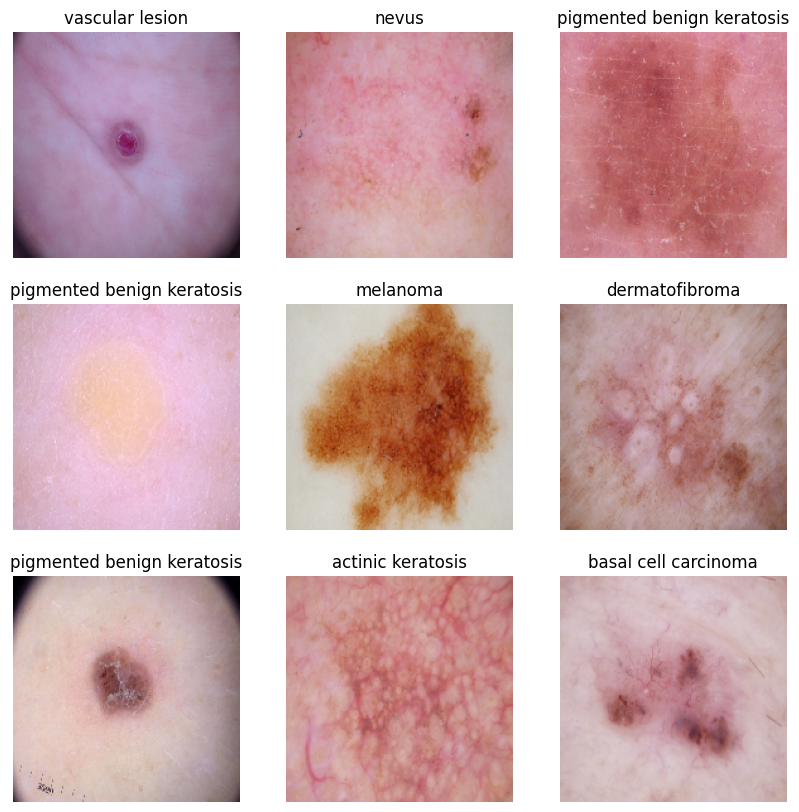

In [11]:
import matplotlib.pyplot as plt
# To display a 3x3 grid of images from the first batch of the training dataset.
# The title of each image will be its class name.

# Retrieve a batch of images from the training dataset
image_batch, label_batch = next(iter(train_ds))

# Configure the matplotlib figure
plt.figure(figsize=(10, 10))

# Display the first 9 images from the training dataset
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
num_classes = 9

model = tf.keras.Sequential([
    # Scaling the pixel values from 0-255 to 0-1
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolution layer with 16 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

The model is a sequential model with the following layers:

1. A rescaling layer that rescales the pixel values of the input images from a range of 0-255 to 0-1.

2. Three sets of convolutional layers (Conv2D) followed by max pooling layers (MaxPooling2D). The first convolutional layer extracts 16 features with a 3x3 filter and a 'relu' activation function. The second convolutional layer extracts 32 features, and the third one extracts 64 features, all with the same settings.

3. A flatten layer to transform the 2D matrix data to a 1D array.

4. A dense (fully connected) layer with 128 units and a 'relu' activation function.

5. The final dense layer that outputs the class probabilities with the number of neurons equal to the number of classes (9 in this case).

The model is compiled with an 'adam' optimizer and the loss function is set to 'SparseCategoricalCrossentropy' with logits. The accuracy of the model is tracked during training.

The model summary shows that it has a total of 3,989,801 parameters, all of which are trainable. The input shape is (180, 180, 3), and the output shape of the final layer is (9), corresponding to the probabilities of the 9 classes.

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 404s 2s/step - loss: 2.1614 - accuracy: 0.2104 - val_loss: 1.9993 - val_accuracy: 0.2260
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.7879 - accuracy: 0.3482 - val_loss: 1.6518 - val_accuracy: 0.3647
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5085 - accuracy: 0.4777 - val_loss: 1.6100 - val_accuracy: 0.4609
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4594 - accuracy: 0.4794 - val_loss: 1.4710 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3242 - accuracy: 0.5441 - val_loss: 1.6492 - val_accuracy: 0.4251
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2861 - accuracy: 0.5452 - val_loss: 1.3984 - val_accuracy: 0.5593
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1656 - accuracy: 0.5971 - val_loss: 1.3838 - val_accuracy: 0.5436
Epoch 8/20
56

### Visualizing training results

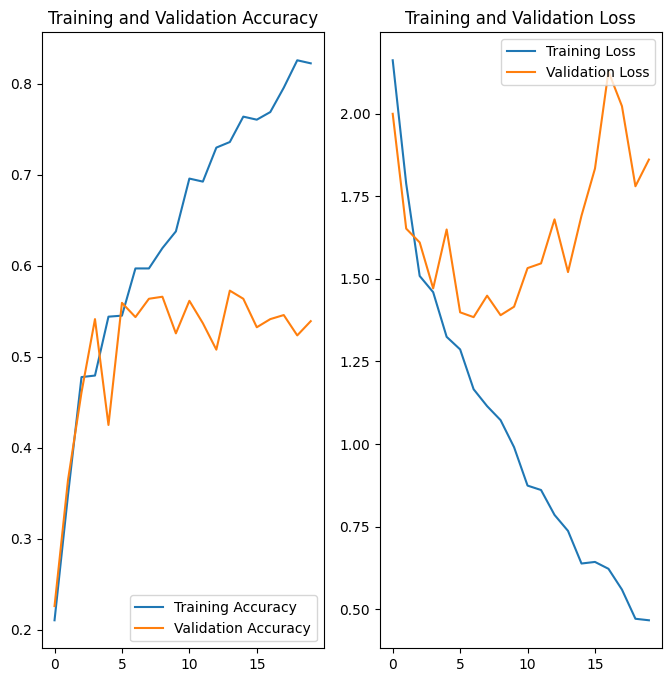

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After training the model for 20 epochs, the following observations can be made:

1. The model starts with a training accuracy of 21.04% and a validation accuracy of 22.60%, indicating initial learning from the data.

2. With progression through epochs, the model's accuracy significantly improves on the training set, reaching up to 82.25%. However, the highest accuracy on the validation set is only 56.60%.

3. The loss on the training set shows a steady decrease from 2.1614 to 0.4662 across the epochs, which indicates that the model is learning and making better predictions on the training data.

4. However, there's a large gap between the training and validation accuracy, particularly in later epochs. This is a strong indicator of overfitting, as the model is becoming more specialized to the training data.

5. The validation accuracy does not show a clear increasing trend and fluctuates between 52.35% to 56.60%, suggesting that the model may not generalize well to unseen data.

6. Additionally, the validation loss increases after the 5th epoch, which is a clear indication of overfitting. The model seems to perform worse on the validation set with increasing epochs, implying it's not learning the generalized patterns in the data.

7. The highest validation accuracy achieved is 56.60% in epoch 9, which is relatively low. This suggests that the model, in its current state, may not perform optimally on unseen data.

These observations strongly suggest that the model is overfitting to the training data. It would be beneficial to apply techniques to prevent overfitting, like adding regularization, implementing early stopping, or using more varied training data.

In [18]:
# Data Augumentation Strategy.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,   # randomly flip images horizontally
    zoom_range=0.1,         # randomly zoom image
)

# Apply the data augmentation to the training dataset
train_ds_augmented = datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=123
)

Found 2239 images belonging to 9 classes.


In [19]:
train_ds_augmented = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
  layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

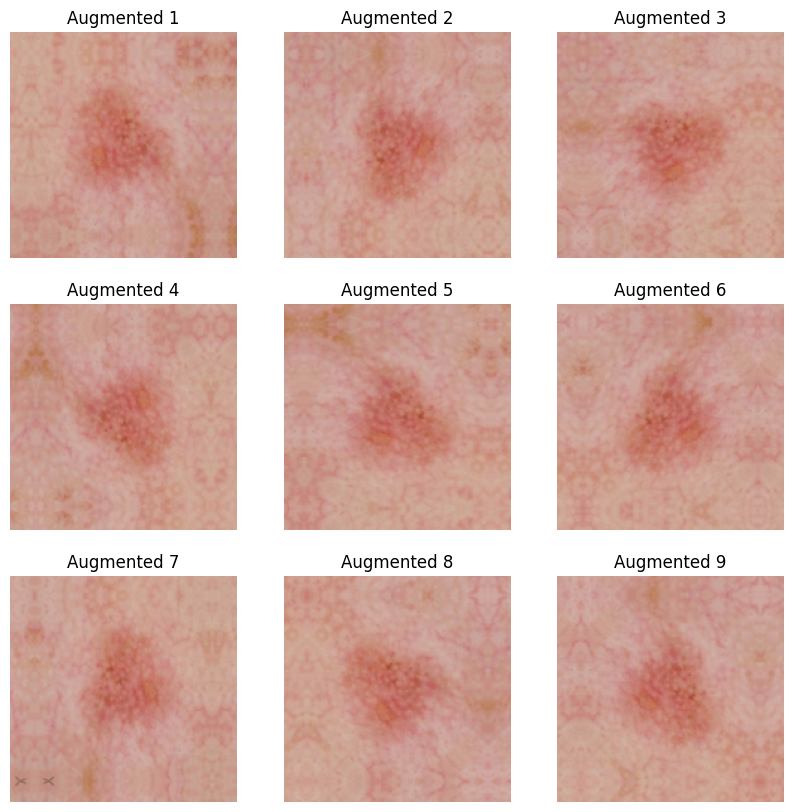

In [20]:
plt.figure(figsize = (10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = train_ds_augmented(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.title("Augmented {}".format(i + 1))
    plt.axis("off")

  plt.show()

### Todo:
### Create the model, compile and train the model


In [21]:
num_classes = 9

model = tf.keras.Sequential([
    # Scaling the pixel values from 0-255 to 0-1
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolution layer with 16 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    #Dropout layer with 20% Fraction of the input units to drop.
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),

    layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

The model is a sequential model with the following layers:

1. The model begins with a rescaling layer, which normalizes pixel values from the range 0-255 to 0-1, maintaining the color information in the three RGB channels. The input shape is defined here as (img_height, img_width, 3), indicating color images.

2. It then passes through four convolutional layers, each followed by a max-pooling layer. The convolutional layers use 3x3 filters with the 'relu' activation function and 'same' padding. The feature map sizes double after each convolutional layer, starting from 16 and going up to 128. Each max pooling layer down-samples the previous layer's output by a factor of 2 in both width and height dimensions.

3. A dropout layer is added with a rate of 0.2, which randomly sets 20% of input units to 0 at each update during training. This is a regularization method that helps prevent overfitting.

4. The model is then flattened to a 1D array, which prepares the multi-dimensional convolutional layer outputs for the upcoming fully connected layer.

5. A dense layer with 256 units and 'relu' activation function is used to learn complex representations.

6. The final layer is another dense layer with 'softmax' activation function, which is typically used in multi-class classification problems. It has 'num_classes' (9 in this case) output units, each representing the predicted probability for each class.

The model contains a total of 4,064,937 parameters, all of which are trainable. This makes it a fairly large model with potential for capturing complex patterns in the data.

### Training the model

In [23]:
## train model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 4s 33ms/step - loss: 2.0503 - accuracy: 0.2076 - val_loss: 1.8882 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.7460 - accuracy: 0.3700 - val_loss: 1.6513 - val_accuracy: 0.4161
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5579 - accuracy: 0.4520 - val_loss: 1.4730 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4602 - accuracy: 0.4877 - val_loss: 1.5185 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3908 - accuracy: 0.5184 - val_loss: 1.3908 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3106 - accuracy: 0.5273 - val_loss: 1.4557 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.2116 - accuracy: 0.5658 - val_loss: 1.3452 - val_accuracy: 0.5436
Epoch 8/20
56/56 [======

### Visualizing the results

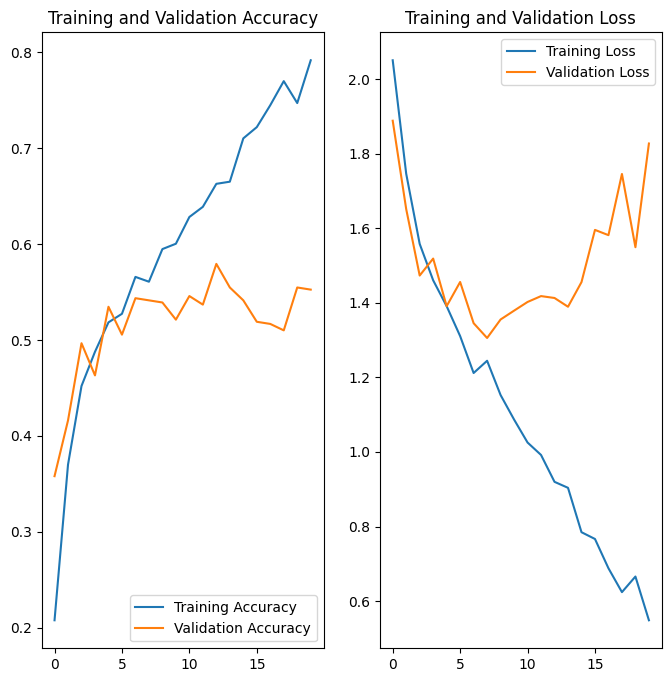

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Following are the key insights that can be observed after training the Second model for 20 epochs:

1. The model starts with a low accuracy of 20.76% on the training set and 35.79% on the validation set in the first epoch.

2. As the epochs progress, the model's accuracy improves significantly, reaching 79.19% on the training set by the 20th epoch.

3. The validation accuracy also improves during the training but fluctuates throughout the epochs and doesn't exhibit a clear increasing trend. It starts from 35.79% in the first epoch and reaches its peak at 57.94% in the 13th epoch. By the end of the 20th epoch, it decreases to 55.26%.

4. The loss on the training set decreases consistently throughout the epochs, indicating that the model is learning and optimizing its predictions.

5. However, the validation loss does not follow a similar trend. It decreases initially until the 8th epoch, but afterwards, it starts increasing again. This suggests that the model may be overfitting to the training data.

6. Despite the fluctuation, the highest validation accuracy achieved is still relatively low (57.94%), suggesting the model might not perform very well on unseen data.

7. Finally, there's a significant gap between the training and validation accuracy by the end of the 20th epoch (79.19% on the training set vs. 55.26% on the validation set), further indicating the overfitting issue.

In conclusion, while the model learns well from the training data, it struggles to generalize to the validation data, which suggests overfitting.


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
# Create a pandas DataFrame (original_df) containing information about
# image paths and corresponding class labels.
path_list = []
class_list = []

for class_name in class_names:
    class_dir = data_dir_train / class_name

    for image_path in class_dir.glob('*.jpg'):
        path_list.append(str(image_path))
        class_list.append(class_name)

df = {
    'Path': path_list,
    'Class': class_list
}

class_df = pd.DataFrame(df)
class_df

,Path,Class
0,/content/gdrive/My Drive/Dataset/Melanoma Data...,actinic keratosis
1,/content/gdrive/My Drive/Dataset/Melanoma Data...,actinic keratosis
2,/content/gdrive/My Drive/Dataset/Melanoma Data...,actinic keratosis
3,/content/gdrive/My Drive/Dataset/Melanoma Data...,actinic keratosis
4,/content/gdrive/My Drive/Dataset/Melanoma Data...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/Dataset/Melanoma Data...,vascular lesion
2235,/content/gdrive/My Drive/Dataset/Melanoma Data...,vascular lesion
2236,/content/gdrive/My Drive/Dataset/Melanoma Data...,vascular lesion
2237,/content/gdrive/My Drive/Dataset/Melanoma Data...,vascular lesion


In [26]:
# Count the number of samples per class
class_counts = class_df['Class'].value_counts()

# Find the class with the least number of samples
class_with_least_samples = class_counts.idxmin()

# Calculate the proportion of samples for each class
class_proportions = class_counts / len(class_df)

# Display the number of samples per class as a table
class_table = pd.DataFrame({
    'Class': class_counts.index,
    'Count': class_counts.values,
    'Proportion': class_proportions.values
})

class_table

,Class,Count,Proportion
0,pigmented benign keratosis,462,0.206342
1,melanoma,438,0.195623
2,basal cell carcinoma,376,0.167932
3,nevus,357,0.159446
4,squamous cell carcinoma,181,0.080840
5,vascular lesion,139,0.062081
6,actinic keratosis,114,0.050916
7,dermatofibroma,95,0.042430
8,seborrheic keratosis,77,0.034390


Here's a summary:

1. The dataset contains the highest count of 'pigmented benign keratosis' with 462 instances, making up 20.63% of the total data.

2. 'Melanoma' follows closely behind with 438 instances, making up 19.56% of the dataset.

3. 'Basal cell carcinoma' and 'nevus' comprise 16.79% and 15.94% of the data respectively, with 376 and 357 instances each.

4. 'Squamous cell carcinoma', 'vascular lesion', 'actinic keratosis', 'dermatofibroma', and 'seborrheic keratosis' make up the rest of the data. Among them, 'squamous cell carcinoma' is the most prevalent with 181 instances (8.08%), and 'seborrheic keratosis' is the least prevalent with 77 instances (3.44%).

In summary, the dataset is somewhat imbalanced, with 'pigmented benign keratosis' and 'melanoma' being the most common classes and 'seborrheic keratosis' being the least common. This could potentially influence the model's ability to accurately predict less prevalent classes.

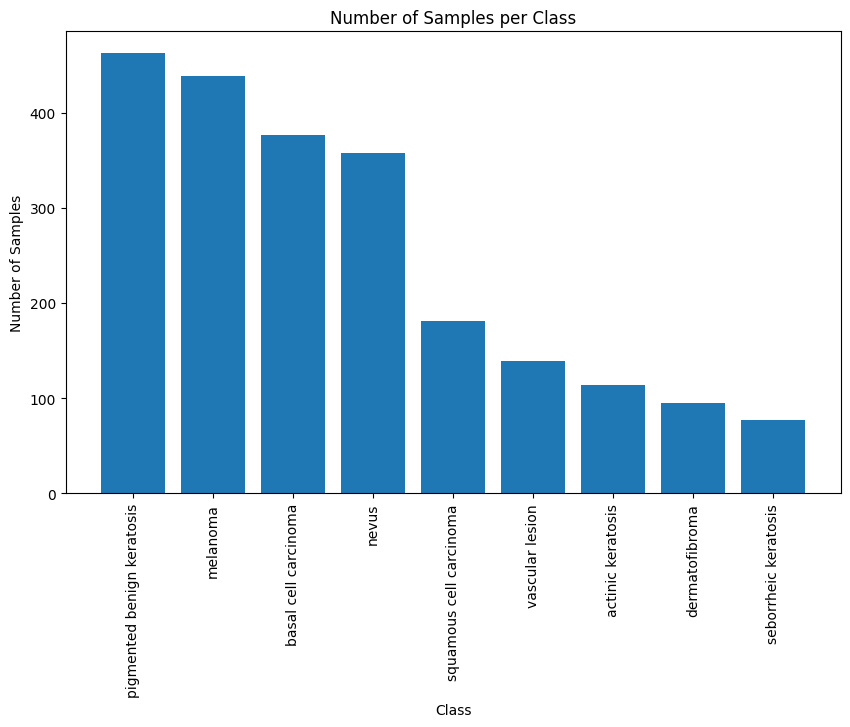

In [27]:
# Plot the number of samples per class
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')
plt.xticks(rotation=90)
plt.show()

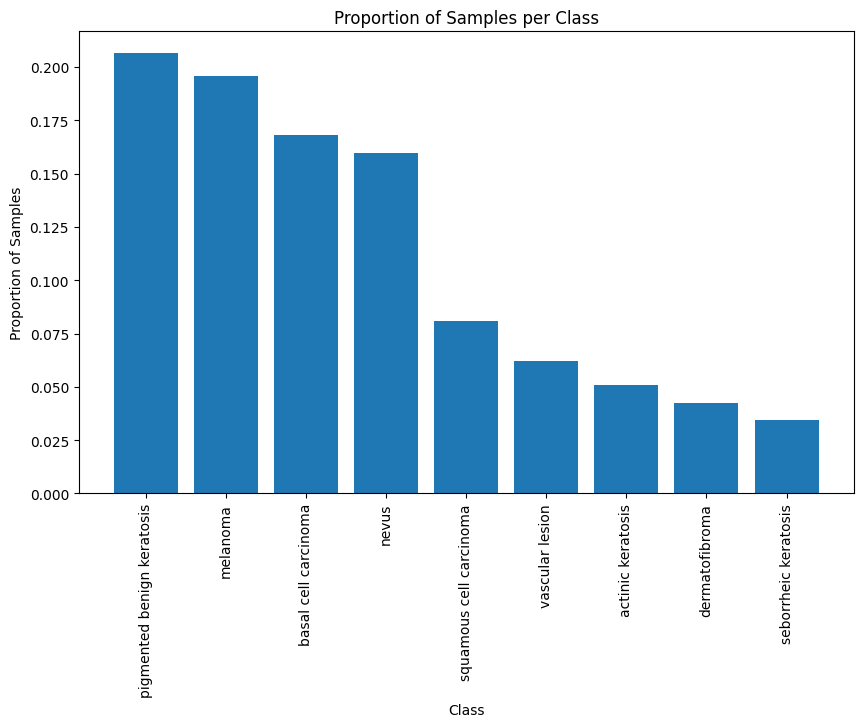

In [28]:
# Plot the proportion of samples per class
plt.figure(figsize=(10, 6))
plt.bar(class_proportions.index, class_proportions.values)
plt.xlabel('Class')
plt.ylabel('Proportion of Samples')
plt.title('Proportion of Samples per Class')
plt.xticks(rotation=90)
plt.show()

####  Write your findings here:
#### Question 1: Which class has the least number of samples?
The class "seborrheic keratosis" has the least number of samples, with a count of 77.

#### Question 2: Which classes dominate the data in terms proportionate number of samples?
The classes that dominate the data in terms of the proportionate number of samples are:

1.   "pigmented benign keratosis" with a proportion of 0.206342 (20.63%)
2.   "melanoma" with a proportion of 0.195623 (19.56%)
3.   "basal cell carcinoma" with a proportion of 0.167932 (16.79%) <br><br>
These three classes have the highest proportions of samples in the dataset, indicating that they are more represented compared to the other classes.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset = data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(str(path_to_training_dataset), i), save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma Dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBA2AFA7BB0>: 100%|██████████| 500/500 [00:26<00:00, 18.56 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma Dataset/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBA2AFC9CF0>: 100%|██████████| 500/500 [00:27<00:00, 18.38 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBAC4279F60>: 100%|██████████| 500/500 [00:23<00:00, 20.99 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBAB01837C0>: 100%|██████████| 500/500 [01:36<00:00,  5.18 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FBB515D6AD0>: 100%|██████████| 500/500 [01:33<00:00,  5.32 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBA2AF32380>: 100%|██████████| 500/500 [00:21<00:00, 22.84 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBAC42AC5E0>: 100%|██████████| 500/500 [00:47<00:00, 10.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA2B2EAA10>: 100%|██████████| 500/500 [00:23<00:00, 21.55 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA2AFC8EE0>: 100%|██████████| 500/500 [00:22<00:00, 21.90 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Dataset/Melanoma Dataset/Train")

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [32]:
class_image_count = {}

for i in class_names:
  # Augmentor has created 'output' subdirectory in each class directory
  class_dir = os.path.join(str(data_dir_train), i, 'output')

  # Get list of all files in the directory
  file_list = os.listdir(class_dir)

  # Count number of images (assuming they are all .jpg files)
  num_images = len([f for f in file_list if f.endswith('.jpg')])

  # Save results into dictionary
  class_image_count[i] = num_images

# Convert the dictionary to dataframe
df = pd.DataFrame(list(class_image_count.items()), columns=['Class', 'Number of Augmented Images'])

df

,Class,Number of Augmented Images
0,actinic keratosis,500
1,basal cell carcinoma,500
2,dermatofibroma,500
3,melanoma,500
4,nevus,500
5,pigmented benign keratosis,500
6,seborrheic keratosis,500
7,squamous cell carcinoma,500
8,vascular lesion,500


In [33]:
# Loop over each class subdirectory
for i in class_names:
  # Directory path for the original images
  class_dir = os.path.join(str(data_dir_train), i)

  # Directory path for the augmented images
  output_dir = os.path.join(class_dir, 'output')

  # Get list of all files in the original directory
  original_file_list = os.listdir(class_dir)

  # Count number of original images (assuming they are all .jpg files)
  num_original_images = len([f for f in original_file_list if f.endswith('.jpg')])

  # Get list of all files in the output directory
  output_file_list = os.listdir(output_dir)

  # Count number of augmented images (assuming they are all .jpg files)
  num_augmented_images = len([f for f in output_file_list if f.endswith('.jpg')])

  # Get total count
  total_images = num_original_images + num_augmented_images

  print(f"For class '{i}', number of original images: {num_original_images}, number of augmented images: {num_augmented_images}, total: {total_images}")


For class 'actinic keratosis', number of original images: 114, number of augmented images: 500, total: 614
For class 'basal cell carcinoma', number of original images: 376, number of augmented images: 500, total: 876
For class 'dermatofibroma', number of original images: 95, number of augmented images: 500, total: 595
For class 'melanoma', number of original images: 438, number of augmented images: 500, total: 938
For class 'nevus', number of original images: 357, number of augmented images: 500, total: 857
For class 'pigmented benign keratosis', number of original images: 462, number of augmented images: 500, total: 962
For class 'seborrheic keratosis', number of original images: 77, number of augmented images: 500, total: 577
For class 'squamous cell carcinoma', number of original images: 181, number of augmented images: 500, total: 681
For class 'vascular lesion', number of original images: 139, number of augmented images: 500, total: 639


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
from pathlib import Path

# Empty lists to hold file paths and corresponding classes
path_list = []
class_list = []

# Directory path for the augmented images
data_dir_train_output = Path(data_dir_train)

# Loop over each class
for class_folder in data_dir_train_output.iterdir():
    if class_folder.is_dir():
        # Get list of all .jpg files in the main directory
        for image_path in class_folder.glob('*.jpg'):
            # Append file path and class to respective lists
            path_list.append(str(image_path))
            class_list.append(class_folder.name)

        output_folder = class_folder / 'output'
        if output_folder.exists() and output_folder.is_dir():
            # Get list of all .jpg files in the output directory
            for image_path in output_folder.glob('*.jpg'):
                # Append file path and class to respective lists
                path_list.append(str(image_path))
                class_list.append(class_folder.name)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'Path': path_list,
    'Class': class_list,
})

df

,Path,Class
0,/content/gdrive/My Drive/Dataset/Melanoma Data...,actinic keratosis
1,/content/gdrive/My Drive/Dataset/Melanoma Data...,actinic keratosis
2,/content/gdrive/My Drive/Dataset/Melanoma Data...,actinic keratosis
3,/content/gdrive/My Drive/Dataset/Melanoma Data...,actinic keratosis
4,/content/gdrive/My Drive/Dataset/Melanoma Data...,actinic keratosis
...,...,...
6734,/content/gdrive/My Drive/Dataset/Melanoma Data...,dermatofibroma
6735,/content/gdrive/My Drive/Dataset/Melanoma Data...,dermatofibroma
6736,/content/gdrive/My Drive/Dataset/Melanoma Data...,dermatofibroma
6737,/content/gdrive/My Drive/Dataset/Melanoma Data...,dermatofibroma


In [35]:
df['Class'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Class, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [37]:
data_dir_train

PosixPath('/content/gdrive/My Drive/Dataset/Melanoma Dataset/Train')

In [38]:
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Dataset/Melanoma Dataset/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [40]:
num_classes = 9

model = tf.keras.Sequential([
    # Scaling the pixel values from 0-255 to 0-1
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolution layer with 16 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    #Dropout layer with 20% Fraction of the input units to drop.
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),

    layers.Dense(num_classes, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 45, 45, 64)       

Here's a summary of the Thord Model structure:

1. It starts with an input layer that rescales the pixel values of the images from the 0-255 range to 0-1 range. This is done to normalize the data, helping the network to learn more effectively.

2. The network then has a series of convolutional layers, each with a different number of features (16, 32, 64, 128 respectively). Each of these convolutional layers uses a 3x3 filter and a ReLU activation function. Following each convolutional layer, there is a max pooling layer with a 2x2 pool size. These layers extract the features from the images and reduce their dimensions, retaining the most important information.

3. After the convolutional and max pooling layers, there is a dropout layer with a dropout rate of 0.2. This means that during training, around 20% of the neurons in the layer are "turned off" randomly to prevent overfitting.

4. The network then has a flatten layer, which takes the multi-dimensional output of the previous layer and flattens it into a one-dimensional array.

5. After that, there's a fully connected (dense) layer with 256 units and a ReLU activation function, which acts as a classifier on the features extracted by the convolutional layers.

6. Finally, the output layer is a dense layer with 9 units using a softmax activation function to output a probability distribution over the classes.

The model contains a total of 4,064,937 parameters, all of which are trainable. This makes it a fairly large model with potential for capturing complex patterns in the data.

#### **Todo:**  Train your model

In [42]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 50s 274ms/step - loss: 1.9783 - accuracy: 0.2457 - val_loss: 1.5981 - val_accuracy: 0.3987
Epoch 2/30
169/169 [==============================] - 38s 219ms/step - loss: 1.5517 - accuracy: 0.4108 - val_loss: 1.3810 - val_accuracy: 0.4840
Epoch 3/30
169/169 [==============================] - 35s 203ms/step - loss: 1.3860 - accuracy: 0.4802 - val_loss: 1.2782 - val_accuracy: 0.5145
Epoch 4/30
169/169 [==============================] - 41s 234ms/step - loss: 1.2082 - accuracy: 0.5441 - val_loss: 1.2832 - val_accuracy: 0.5093
Epoch 5/30
169/169 [==============================] - 37s 212ms/step - loss: 1.0615 - accuracy: 0.6076 - val_loss: 1.1427 - val_accuracy: 0.5650
Epoch 6/30
169/169 [==============================] - 37s 212ms/step - loss: 0.8927 - accuracy: 0.6751 - val_loss: 0.9382 - val_accuracy: 0.6592
Epoch 7/30
169/169 [==============================] - 35s 200ms/step - loss: 0.7014 - accuracy: 0.7491 - val_loss: 0.8637 - val_accuracy: 0.6

Summary:

1. The model was trained for 30 epochs on a Convolutional Neural Network.

2. Over these epochs, the training loss decreased from 1.9783 to 0.1196, indicating that the model's predictions were increasingly aligning with the actual results from the training set.

3. Simultaneously, the training accuracy improved from 24.57% to 95.05%, showing an improved performance of the model on training data.

4. On the validation set, the loss decreased from 1.5981 in epoch 1 to 0.4794 in epoch 23, but it started to increase afterwards, reaching 0.5722 in epoch 30. This suggests that the model might be overfitting the training data after epoch 23.

5. The validation accuracy increased from 39.87% to a peak of 86.56% in epoch 24, but decreased to 83.82% by the end of training, further indicating potential overfitting after epoch 24.

6. Therefore, the model's best generalization performance appears to be around epoch 24. It would be beneficial to stop the training at this point to prevent overfitting.

#### **Todo:**  Visualize the model results

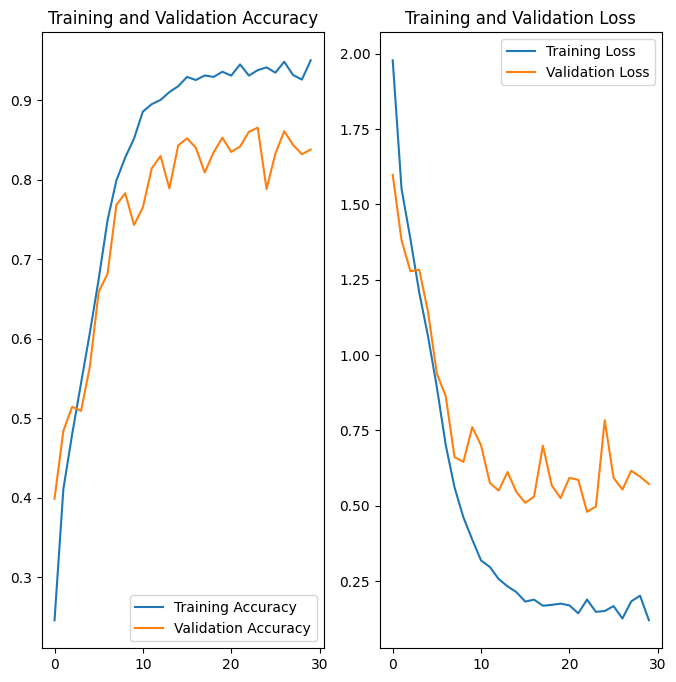

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Did you get rid of underfitting/overfitting?**

The Third model seems to perform better as the number of epochs increases, indicating that it is learning from the data and improving its predictions over time. However, it's essential to discuss underfitting and overfitting in more detail:

1. Underfitting - This occurs when a model fails to capture the underlying patterns of the data. Indications of underfitting include poor performance on the training data. From the logs, we cam see that our model achieves an accuracy of 0.9505 (or 95.05%) on the training data by the end of the 30th epoch, which indicates that the model is not underfitting, as it performs well on the training data.

2. Overfitting - This happens when the model learns the training data too well, including its noise and outliers, and performs poorly on unseen data. Signs of overfitting include a high accuracy on the training data but a significantly lower accuracy on the validation data. From the logs, we cam see that the final validation accuracy is 0.8382 (or 83.82%), which is somewhat lower than the training accuracy but not significantly so. However, we can observe that after about the 13th epoch, the validation loss starts increasing while the training loss continues to decrease. This is a sign of overfitting as it shows the model is continuing to adapt itself to the training data (hence the decreasing training loss) but is performing worse on the validation data (hence the increasing validation loss).




**Did class rebalance help?**

The rebalancing of the classes was done correctly, as seen in the even distribution of samples across all classes in the rebalanced dataset. However, the key test of whether this rebalancing helped comes from the performance of the model.

From the results, the model's accuracy is approximately 95% on the training data and 83% on the validation data, indicating good overall performance. This suggests that class rebalancing may have been beneficial.

Yet, to confirm if class rebalancing truly helped, you'd need to compare these results to a model trained on the unbalanced data. If the rebalanced model performs significantly better, particularly for the underrepresented classes, then it's clear that the rebalancing has helped.

In conclusion, with the given model, there are signs that class rebalancing have been beneficial.